In [1]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import distributions as D

Parameter Settings
-------------------


In [2]:
num_epochs = 50
batch_size = 128
learning_rate = 1e-3
use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
class VAE(nn.Module):
  def __init__(self, device):
    super(VAE, self).__init__()

    self.device = device
    self.c = 16
    self.z_dims = 16

    # Layers for q(z|x):
    self.qz_conv1 = nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
    self.qz_conv2 = nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
    self.qz_mu = nn.Linear(in_features=self.c*2*7*7, out_features=self.z_dims)
    self.qz_pre_sp = nn.Linear(in_features=self.c*2*7*7, out_features=self.z_dims)

    # Layers for p(x|z):
    self.px_l1 = nn.Linear(in_features=self.z_dims, out_features=self.c*2*7*7)
    self.px_conv1 = nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1)
    self.px_conv2 = nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1)

  def q_z(self, x):
    h = F.relu(self.qz_conv1(x))
    h = F.relu(self.qz_conv2(h))
    h = h.view(h.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
    z_mu = self.qz_mu(h)
    z_pre_sp = self.qz_pre_sp(h)
    z_std = F.softplus(z_pre_sp)
    return self.reparameterize(z_mu, z_std), z_mu, z_std

  def p_x(self, z):
    h = self.px_l1(z)
    h = h.view(h.size(0), self.c*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
    h = F.relu(self.px_conv1(h))
    x = torch.sigmoid(self.px_conv2(h)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
    return x

  def reparameterize(self, mu, std):
    eps = Variable(torch.randn(mu.size()))
    eps = eps.to(self.device)

    return mu + eps * std

  def sample_x(self, num=10):
    # sample latent vectors from the normal distribution
    z = torch.randn(num, self.z_dims)
    z = z.to(self.device)

    x_prob = self.p_x(z)

    return x_prob

  def reconstruction(self, x):
    z, _, _ = self.q_z(x)
    x_prob = self.p_x(z)

    return x_prob

  def forward(self, x):
    z, qz_mu, qz_std = self.q_z(x)

    x_prob = self.p_x(z)

    # For likelihood : <log p(x|z)>_q :
    elbo = torch.sum(torch.flatten(x.view(-1, 784) * torch.log(x_prob.view(-1, 784) + 1e-8)
                                    + (1 - x.view(-1, 784)) * torch.log(1 - x_prob.view(-1, 784) + 1e-8),
                                    start_dim=1),
                      dim=-1)
    
    qz = D.normal.Normal(qz_mu, qz_std)
    qz = D.independent.Independent(qz, 1)
    pz = D.normal.Normal(torch.zeros_like(z), torch.ones_like(z))
    pz = D.independent.Independent(pz, 1)
    # For : <log p(z)>_q
    elbo += pz.log_prob(z)

    # For : -<log q(z|x)>_q
    elbo -= qz.log_prob(z)

    return -elbo.mean()



In [5]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)
vae = VAE(device)
vae = vae.to(device)

cuda:0


In [6]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        optimizer.zero_grad()
        
        image_batch = image_batch.to(device)

        loss = vae(image_batch)
        
        # backpropagation
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average negative ELBO: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average negative ELBO: 171.065991
Epoch [2 / 50] average negative ELBO: 121.802300
Epoch [3 / 50] average negative ELBO: 115.891312
Epoch [4 / 50] average negative ELBO: 112.670983
Epoch [5 / 50] average negative ELBO: 110.653911
Epoch [6 / 50] average negative ELBO: 109.261439
Epoch [7 / 50] average negative ELBO: 108.294229
Epoch [8 / 50] average negative ELBO: 107.473241
Epoch [9 / 50] average negative ELBO: 106.867143
Epoch [10 / 50] average negative ELBO: 106.325954
Epoch [11 / 50] average negative ELBO: 105.888223
Epoch [12 / 50] average negative ELBO: 105.495360
Epoch [13 / 50] average negative ELBO: 105.170285
Epoch [14 / 50] average negative ELBO: 104.798399
Epoch [15 / 50] average negative ELBO: 104.589140
Epoch [16 / 50] average negative ELBO: 104.334215
Epoch [17 / 50] average negative ELBO: 104.111011
Epoch [18 / 50] average negative ELBO: 103.914189
Epoch [19 / 50] average negative ELBO: 103.739275
Epoch [20 / 50] average negative ELBO: 103.580

In [ ]:
# c=16, z=16: Epoch [100 / 100] average reconstruction error: 100.382538

In [ ]:
# this is how the VAE parameters can be saved:
# torch.save(hvae.state_dict(), './pretrained/hvae.pth')

Original images


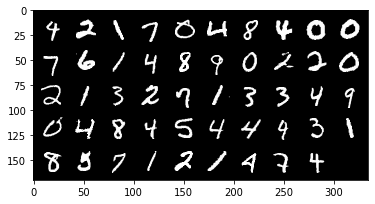

VAE reconstruction:


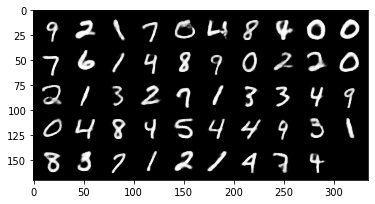

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images = vae.reconstruction(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

In [9]:
vae.eval()

with torch.no_grad():
    images = images.to(device)
    nElbo = vae(images)
    print(nElbo)


rand = torch.rand_like(images)

with torch.no_grad():
    rand = rand.to(device)
    nElbo = vae(rand)
    print(nElbo)

zeros = torch.zeros_like(images)

with torch.no_grad():
    zeros = zeros.to(device)
    nElbo = vae(zeros)
    print(nElbo)

tensor(99.4132, device='cuda:0')
tensor(3201.4253, device='cuda:0')
tensor(47.9732, device='cuda:0')


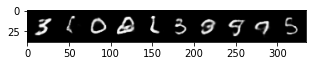

In [13]:
vae.eval()

with torch.no_grad():

    # sample images
    img_samples = vae.sample_x()
    img_samples = img_samples.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_samples,10,5))
    plt.show()